## **Advances in Data Mining**

Stephan van der Putten | (s1528459) | stvdputtenjur@gmail.com  
Theo Baart | s2370328 | s2370328@student.leidenuniv.nl

### **Assignment 3**
This assignment is concerned with performing an analysis of and execute PageRank on the wikipedia links given in the `wikilink_graph.2004-03-01.csv` file. In order to do this the assignment is split up into four subtasks with each subtask receiving its dedicated `.ipynb` file. See each specific file for details on what this notebook accomplishes.

Note all implementations are based on the assignment guidelines and helper files given as well as the documentation of the used functions. 

#### **PageRank Algorithm (Improved)**
This notebook executes the PageRank algorithm using the improved storage method and algorithm as presented in the lecture (see also slide 18 of the instructional slideset). Additionally, some basic analaysis is performed and the results are compared to the "Sparse" implementation of PageRank.
___

### **Helper Functions**
This section contains functions which aid and simplify the code.
___
The following snippet handles all imports.

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.sparse
from scipy.sparse import csr_matrix
from collections import defaultdict

The class `PageRank` is our implementation for the Pagerank Algorithm

In [11]:
# class PageRank():
#     def __init__(self):
        

The `load_prepped_data` function is responsible for retrieving the data prepped by `prep.ipynb` and loading it for exploratory data analysis.

In order to do this the function uses the following parameters:
  * `filename` - the name of the file containing the prepped data [default = `prep-data.npz`]
  
Additionally, it returns the following value:
  * `data` - an array representing the prepped data  

In [12]:
def load_prepped_data(filename = 'prep_data.npz'):
    data = scipy.sparse.load_npz(filename)
    return data

The following snippet triggers data loading

In [13]:
data = load_prepped_data()

The `convert_to_custom_format` function is responsible for converting the transition matrix from a sparse matrix representation to the custom format specified in slide 17 of the instructional slideset. It is assumed that the in the sparse matrix each (nonempty) column represents a source node.

In order to do this the function uses the following parameters:
  * `data` - the data as a sparse matrix
  
Additionally, it returns the following value:
  * `converted` - an array representing the converted data  

In [14]:
def convert_to_custom_format(data):
    indices = data.nonzero()
    dictionary = defaultdict(list)
    np_degree = []

    for source, destination in zip(indices[1], indices[0]):
        dictionary[source].append(destination)
    
    for s,d in dictionary.items():
        np_degree += [[s,len(d),np.array(d)]]
    
    return(np.array(np_degree))

### REMOVE EVERTHING BELOW THIS

In [15]:
# TODO REMOVE ME I AM TEMPORARY!
simple_data = load_prepped_data('simple_data.npz')
print(simple_data.todense())

[[0 0 0 1]
 [0 0 1 1]
 [1 0 0 0]
 [1 0 1 0]]


In [16]:
N = data.shape[0]
v_original = np.repeat(1.0 / N , N)
Beta = 0.8
v_new = np.repeat((1-Beta) / N, N)

In [17]:
from sklearn.preprocessing import normalize
M_normalized = normalize(data, norm='l1', axis=0)

In [30]:
%%prun
v_old =  v_original.copy()
mse = []
for i in range(25):
    v_new = (Beta * M_normalized * v_old) + (1 - Beta)*(v_original)
    mse.append(((v_new - M_normalized * v_new)**2).mean())
    v_old = v_new.copy()
# analyse iteration
# MSE: v_old vs. v_new
# v_old == v_new
##TODO: Question 4 Max num of nodes

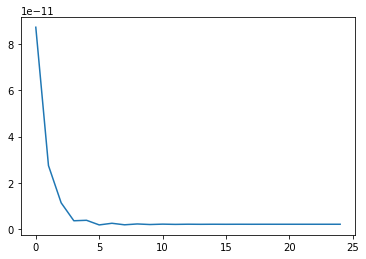

In [31]:
plt.plot(list(range(25)), mse)
plt.show()